# VGG-16


In [1]:
# imports an stuff
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision

import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots

In [2]:
# transformations for the training data with augmentation
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

val_test_transformations = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# batch size and number of labels
batch_size = 64
num_labels = 12

# Directory with data
dataset_path = '../data2'

# Load dataset
dataset = datasets.ImageFolder(root=dataset_path)

# split data
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = total_size - train_size
# split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# apply transformations
train_dataset.dataset.transform = train_transformations
val_dataset.dataset.transform = val_test_transformations

# create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# display sizes
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of validation samples: {len(val_dataset)}')

Number of training samples: 1451
Number of validation samples: 622


In [3]:
# check if GPU is available
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [4]:
# test the model on the validation set
def testVal(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)
            scores = model(images)
            _, predicted = scores.max(1)
            num_correct += (predicted == labels).sum()
            num_samples += predicted.size(0)
    
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [5]:
def train(model, optimizer, num_epochs=1):
    model = model.to(device)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=torch.long)

            optimizer.zero_grad()
            scores = model(images)
            loss = loss_fn(scores, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = scores.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        av_train_loss = train_loss / len(train_loader)
        train_accuracy = 100. * correct_train / total_train
        train_losses.append(av_train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device=device, dtype=dtype)
                labels = labels.to(device=device, dtype=torch.long)
                scores = model(images)
                loss = loss_fn(scores, labels)
                val_loss += loss.item()

                _, predicted = scores.max(1)
                total_val += labels.size(0)
                correct_val += predicted.eq(labels).sum().item()

        av_val_loss = val_loss / len(val_loader)
        val_accuracy = 100. * correct_val / total_val
        val_losses.append(av_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {av_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Validation Loss: {av_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [8]:
class VGG16(nn.Module):
    def __init__(self, num_classes):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 32 * 32, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 128 * 32 * 32)
        x = self.classifier(x)
        return x
        

model = VGG16(num_labels)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6)

In [9]:
# train model and get training and validation losses
train_losses, val_losses, train_accuracies, val_accuracies = train(model, optimizer, num_epochs=50)
print('Finished Training')

Epoch 1/50, Training Loss: 2.4176, Training Accuracy: 18.33%, Validation Loss: 2.4227, Validation Accuracy: 15.59%
Epoch 2/50, Training Loss: 2.3935, Training Accuracy: 19.30%, Validation Loss: 2.3842, Validation Accuracy: 15.59%
Epoch 3/50, Training Loss: 2.2522, Training Accuracy: 25.16%, Validation Loss: 2.1185, Validation Accuracy: 33.92%
Epoch 5/50, Training Loss: 1.9197, Training Accuracy: 37.49%, Validation Loss: 1.9094, Validation Accuracy: 39.39%
Epoch 7/50, Training Loss: 1.6911, Training Accuracy: 47.14%, Validation Loss: 1.7077, Validation Accuracy: 45.66%
Epoch 9/50, Training Loss: 1.4315, Training Accuracy: 55.20%, Validation Loss: 1.5381, Validation Accuracy: 51.61%
Epoch 10/50, Training Loss: 1.3321, Training Accuracy: 58.17%, Validation Loss: 1.4651, Validation Accuracy: 52.89%
Epoch 11/50, Training Loss: 1.2416, Training Accuracy: 61.54%, Validation Loss: 1.4297, Validation Accuracy: 56.27%
Epoch 12/50, Training Loss: 1.1829, Training Accuracy: 63.06%, Validation Loss

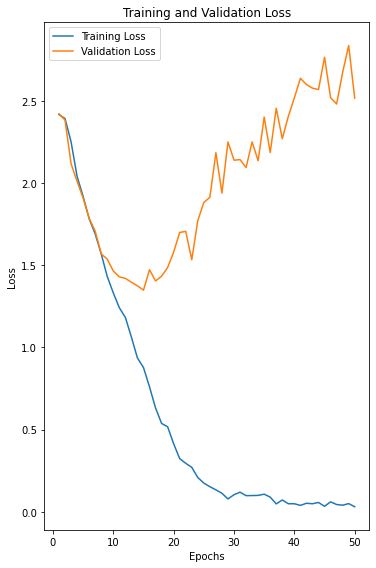

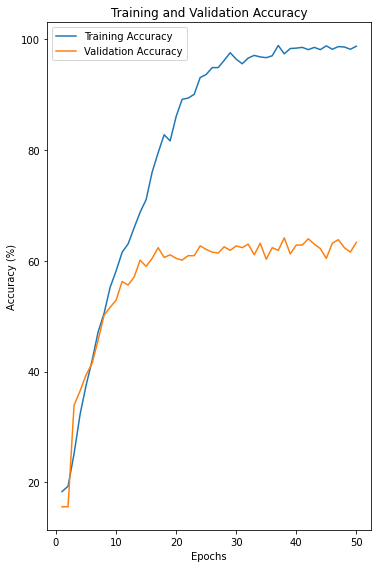

In [10]:
def plots(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# plot everything to check for overfitting
plots(train_losses, val_losses, train_accuracies, val_accuracies)


In [11]:
print('Validation Set Accuracy')
testVal(val_loader, model)

Validation Set Accuracy
Got 394 / 622 correct (63.34)
